# Essential Libraries 

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
import warnings
warnings.filterwarnings('ignore')


# Loading and Merging Twitter Data for Training and Validation

In [8]:
train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
test_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

df = pd.concat([train_df, test_df], ignore_index=True)  
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,NaN,NaN
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,NaN,NaN
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,NaN,NaN
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,NaN,NaN
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
75675,NaN,NaN,NaN,NaN,4891.0,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,NaN,NaN,NaN,NaN,4359.0,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,NaN,NaN,NaN,NaN,2652.0,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75678,NaN,NaN,NaN,NaN,8069.0,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


# Data Preprocessing and Column Consolidation in DataFrame

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                         

In [10]:
col1_name = 'im getting on borderlands and i will murder you all ,'
col2_name = 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'

# Corrected way to replace NaN values
df[col1_name] = df[col1_name].replace(np.nan, '')
df[col2_name] = df[col2_name].replace(np.nan, '')

df['sentences'] = df[col1_name] + df[col2_name]

col3_name = 'Positive'
col4_name = 'Irrelevant'
df[col3_name] = df[col3_name].replace(np.nan, '')
df[col4_name] = df[col4_name].replace(np.nan, '')

df['labels'] = df['Positive'] + df['Irrelevant']
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣",sentences,labels
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,,,I am coming to the borders and I will kill you...,Positive
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,,,im getting on borderlands and i will kill you ...,Positive
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,,,im coming on borderlands and i will murder you...,Positive
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,,,im getting on borderlands 2 and i will murder ...,Positive
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,,,im getting into borderlands and i can murder y...,Positive
...,...,...,...,...,...,...,...,...,...,...
75675,NaN,NaN,,,4891.0,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,⭐️ Toronto is the arts and culture capital of ...,Irrelevant
75676,NaN,NaN,,,4359.0,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
75677,NaN,NaN,,,2652.0,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,Today sucked so it’s time to drink wine n play...,Positive
75678,NaN,NaN,,,8069.0,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,Bought a fraction of Microsoft today. Small wins.,Positive


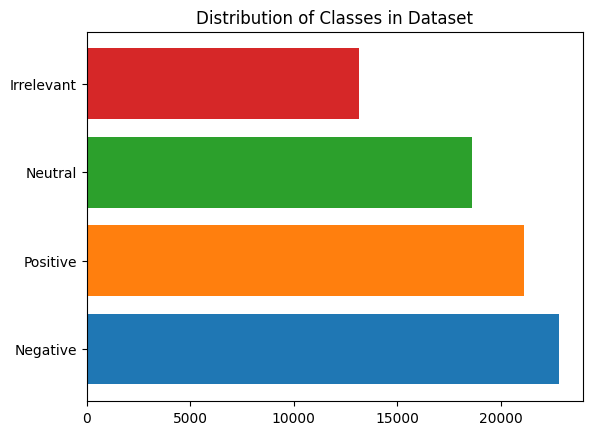

In [11]:
plt.barh(width = df['labels'].value_counts(), y = df['labels'].value_counts().index,color=plt.cm.tab10.colors,)
plt.title('Distribution of Classes in Dataset')
plt.show()

In [12]:
missing_values = df.isna().sum().reset_index()
missing_values.columns = ['Column', 'Missing_Values']
print(missing_values)


                                              Column  Missing_Values
0                                               2401             999
1                                        Borderlands             999
2                                           Positive               0
3  im getting on borderlands and i will murder yo...               0
4                                               3364           74681
5                                           Facebook           74681
6                                         Irrelevant               0
7  I mentioned on Facebook that I was struggling ...               0
8                                          sentences               0
9                                             labels               0


In [13]:
df = df.iloc[:, -2:]
df

,sentences,labels
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive
...,...,...
75675,⭐️ Toronto is the arts and culture capital of ...,Irrelevant
75676,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
75677,Today sucked so it’s time to drink wine n play...,Positive
75678,Bought a fraction of Microsoft today. Small wins.,Positive


# Separating Features (X) and Labels (y) for Machine Learning Model Preparation

In [14]:
X = df['sentences']
y = df['labels']

In [15]:
X.iloc[0]

'I am coming to the borders and I will kill you all,'

# Text Preprocessing with Lemmatization

In [16]:
wordnet = WordNetLemmatizer()

corpus = []
new_y = []
for i in range(len(X)):
    review = re.sub(r'[^a-zA-Z]',' ', X.iloc[i]) 
    # print(review)
    # print('-------------------')
    
    review = review.lower()
    # print(review)
    # print('-------------------')
    
    review = review.split()
    # print(review)
    # print('-------------------')
    
    # review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    # print(review)   
    # print('-------------------')
    
    review = ' '.join(review)
    # print(review)
    # print('-------------------')
    
    if review.strip() != '':
        corpus.append(review)
        new_y.append(y.iloc[i])
# print(corpus)

In [17]:
print(f"Corpus_len: {len(corpus)}")
print(f"Labels_len: {len(new_y)}")


Corpus_len: 73341
Labels_len: 73341


# Encoding Labels and Splitting Data for Training and Testing

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(new_y)
X_train_corpus, X_test_corpus, y_train, y_test = train_test_split(corpus, y_encoded, test_size=0.2, random_state=123)


# Calculating Balanced Class Weights

In [19]:
 classes = np.unique(y_encoded)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{0: 1.4323295055073821,
 1: 0.8267314455766976,
 2: 1.0228299676447619,
 3: 0.8972034644744569}

# Converting Text to Numerical Features using TF-IDF

In [20]:
cv = TfidfVectorizer()
X_train_tfidf = cv.fit_transform(X_train_corpus)  
X_test_tfidf = cv.transform(X_test_corpus)  

# Displaying TF-IDF Scores for Words in a Single Document

In [21]:
features = cv.get_feature_names_out()
first_doc_vector = X_train_tfidf[0]

print("TF-IDF values for the first training document (non-zero only):")
for col_idx, tfidf_score in zip(first_doc_vector.indices, first_doc_vector.data):
    print(f"Feature: {features[col_idx]}, Score: {tfidf_score}")

TF-IDF values for the first training document (non-zero only):
Feature: glitch, Score: 0.2347437137601432
Feature: forced, Score: 0.26486749700228085
Feature: siege, Score: 0.2330814347836604
Feature: chat, Score: 0.4504163931538699
Feature: put, Score: 0.19318471692253988
Feature: still, Score: 0.14358563104141608
Feature: party, Score: 0.4435874860922132
Feature: even, Score: 0.146085877439508
Feature: cut, Score: 0.23023913065420906
Feature: xbox, Score: 0.14983385708784122
Feature: reason, Score: 0.19039120406146
Feature: whatever, Score: 0.23834824018211043
Feature: updated, Score: 0.2431327294592687
Feature: game, Score: 0.29515017314035363
Feature: rainbow, Score: 0.1635375207259962


# Defining Machine Learning Models and Their Parameters for Optimization

In [22]:
models_and_parameters = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight=class_weight_dict),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ['lbfgs', 'liblinear']
        }
    },
    "SVC": {
        "model": SVC(class_weight=class_weight_dict),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "kernel": ['linear', 'rbf'],
            "gamma": ['scale', 'auto']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.1, 0.2]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight=class_weight_dict),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20]
        }
    }
}


# Training and Evaluating Multiple Machine Learning Models with Hyperparameter Optimization

Training LogisticRegression...
LogisticRegression done. Accuracy: 0.8707, Training Time: 101.99 sec
----------------------------------------


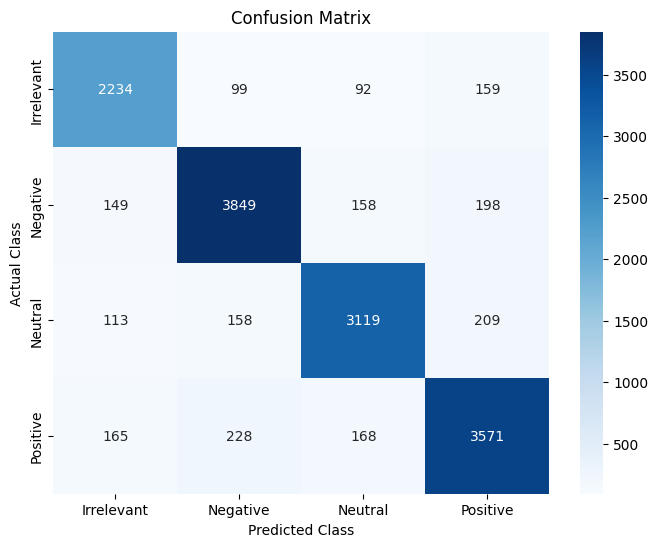

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.84      0.86      0.85      2584
    Negative       0.89      0.88      0.89      4354
     Neutral       0.88      0.87      0.87      3599
    Positive       0.86      0.86      0.86      4132

    accuracy                           0.87     14669
   macro avg       0.87      0.87      0.87     14669
weighted avg       0.87      0.87      0.87     14669

Training SVC...
SVC done. Accuracy: 0.9501, Training Time: 19133.54 sec
----------------------------------------


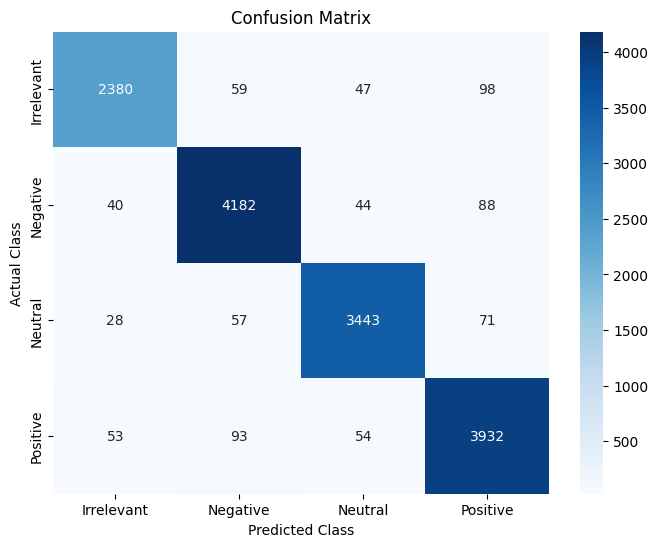

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.95      0.92      0.94      2584
    Negative       0.95      0.96      0.96      4354
     Neutral       0.96      0.96      0.96      3599
    Positive       0.94      0.95      0.95      4132

    accuracy                           0.95     14669
   macro avg       0.95      0.95      0.95     14669
weighted avg       0.95      0.95      0.95     14669

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:00:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

XGBoost done. Accuracy: 0.6591, Training Time: 1321.95 sec
----------------------------------------


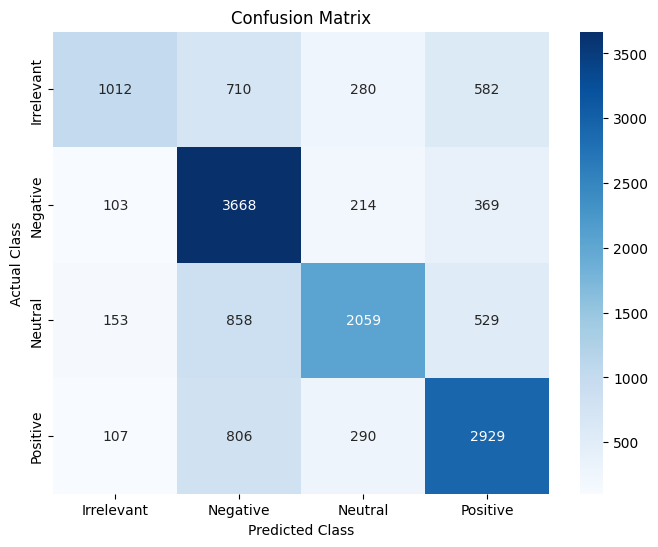

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.74      0.39      0.51      2584
    Negative       0.61      0.84      0.71      4354
     Neutral       0.72      0.57      0.64      3599
    Positive       0.66      0.71      0.69      4132

    accuracy                           0.66     14669
   macro avg       0.68      0.63      0.64     14669
weighted avg       0.67      0.66      0.65     14669

Training RandomForest...
RandomForest done. Accuracy: 0.9333, Training Time: 2340.96 sec
----------------------------------------


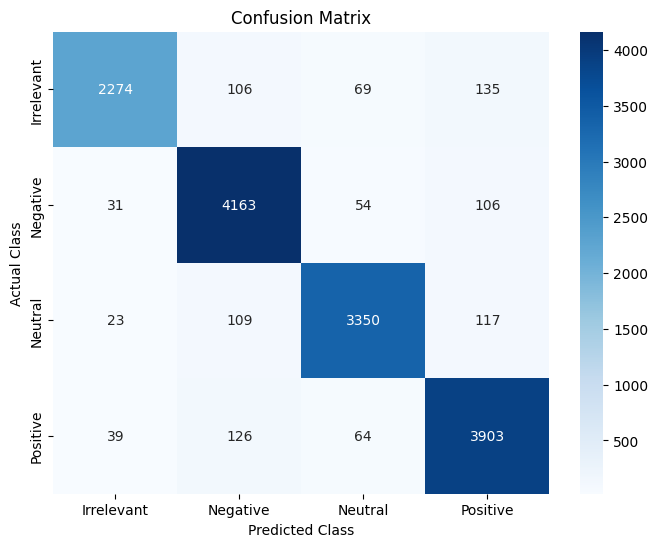

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.88      0.92      2584
    Negative       0.92      0.96      0.94      4354
     Neutral       0.95      0.93      0.94      3599
    Positive       0.92      0.94      0.93      4132

    accuracy                           0.93     14669
   macro avg       0.94      0.93      0.93     14669
weighted avg       0.93      0.93      0.93     14669

                Model                                        Best Params  \
1                 SVC       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}   
3        RandomForest           {'max_depth': None, 'n_estimators': 200}   
0  LogisticRegression                       {'C': 10, 'solver': 'lbfgs'}   
2             XGBoost  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...   

   Accuracy  Training Time (s)  
1  0.950099           19133.54  
3  0.933261            2340.96  
0  0.870748             101.99  
2  0.659077            1321.

In [18]:
results = []

for name, mp in models_and_parameters.items():
    print(f"Training {name}...")
    
    start_time = time.time()
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_tfidf, y_train)
    train_time = time.time() - start_time
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Training Time (s)": round(train_time, 2),
        "Confusion Matrix": cm
    })
    
    print(f"{name} done. Accuracy: {acc:.4f}, Training Time: {train_time:.2f} sec")
    print("-" * 40)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(le.classes_ ),
                yticklabels=list(le.classes_ ))
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    class_report = classification_report(y_test, y_pred, target_names=list(le.classes_ ))
    print("Classification Report:\n", class_report)

results_df = pd.DataFrame([{
    "Model": r["Model"],
    "Best Params": r["Best Params"],
    "Accuracy": r["Accuracy"],
    "Training Time (s)": r["Training Time (s)"]
} for r in results]).sort_values(by="Accuracy", ascending=False)

print(results_df)

# best_result = results_df.iloc[0]
# best_model_name = best_result["Model"]
# best_cm = next(r["Confusion Matrix"] for r in results if r["Model"] == best_model_name)

# plt.figure(figsize=(6,4))
# sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
# plt.title(f"Confusion Matrix for Best Model: {best_model_name}")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

#  Converting Labels to One-Hot Encoding for Neural Networks

In [23]:
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

2025-05-28 19:28:23.084612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748460503.268156      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748460503.325920      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Building and Training a Deep Neural Network for Text Classification

In [27]:
epochs = 100

model = Sequential([
    Dense(512, input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(512, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(256, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    
    Dense(256, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(128, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(128, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    
    Dense(64, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(64, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(32, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(32, kernel_regularizer=l2(1e-6)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
earlystopping = EarlyStopping(restore_best_weights=True, patience=15, verbose=1)
checkpoint = ModelCheckpoint('./original_data_mode_check.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# Training
history = model.fit(
    X_train_tfidf.toarray(), y_train_cat,
    epochs=epochs,
    batch_size=64,
    validation_data=(X_test_tfidf.toarray(), y_test_cat),
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[earlystopping, checkpoint, reduce_lr]
)


Epoch 1/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.4179 - loss: 1.3029 - val_accuracy: 0.8176 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 2/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8709 - loss: 0.3923 - val_accuracy: 0.8879 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 3/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9316 - loss: 0.2148 - val_accuracy: 0.9035 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 4/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9453 - loss: 0.1719 - val_accuracy: 0.9087 - val_loss: 0.3151 - learning_rate: 0.0010
Epoch 5/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9539 - loss: 0.1428 - val_accuracy: 0.9059 - val_loss: 0.3286 - learning_rate: 0.0010
Epoch 6/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9605 - loss: 0.1264 - val_accuracy: 0.9100 - val_loss: 0.3210 - learning_rate: 0.0010
Epoch 7/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.966

Test Accuracy: 93.56%
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


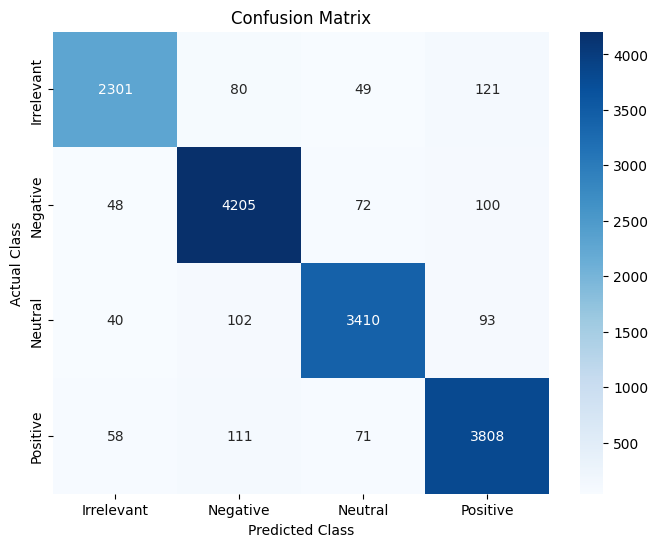

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.94      0.90      0.92      2551
    Negative       0.93      0.95      0.94      4425
     Neutral       0.95      0.94      0.94      3645
    Positive       0.92      0.94      0.93      4048

    accuracy                           0.94     14669
   macro avg       0.94      0.93      0.93     14669
weighted avg       0.94      0.94      0.94     14669



In [30]:
test_loss, test_acc = model.evaluate(X_test_tfidf.toarray(), y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_pred_probs = model.predict(X_test_tfidf.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

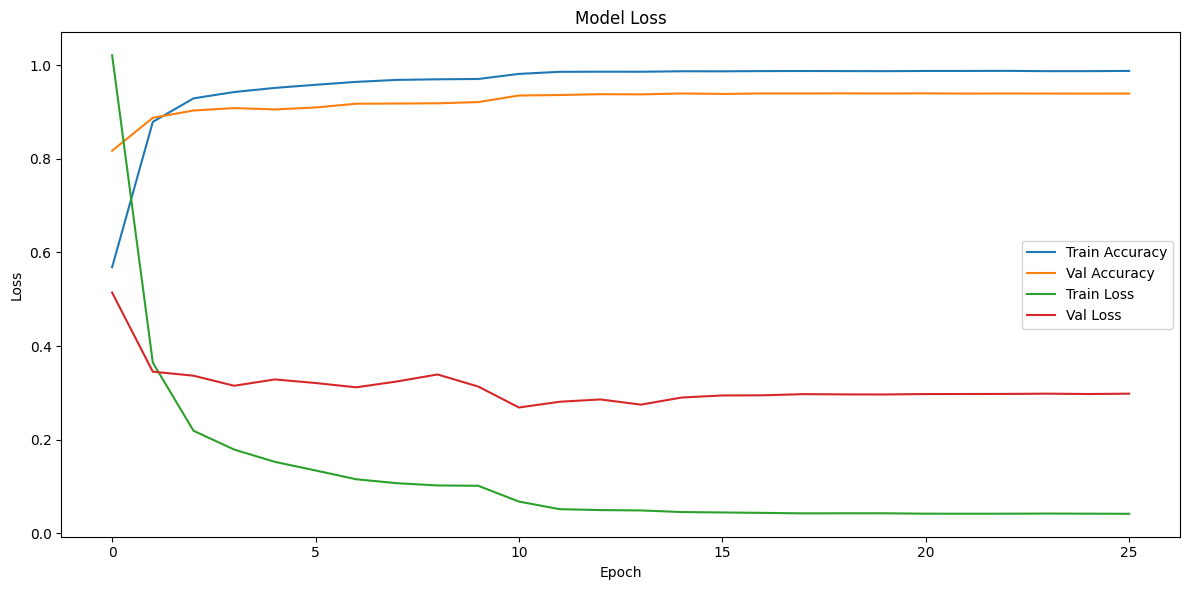

In [29]:
plt.figure(figsize=(12, 6))
    
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()